In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import torch
import torch.nn as nn
import icnn
import numpy as np
from matplotlib import pyplot as plt
import torch.optim as optim

## Generate data

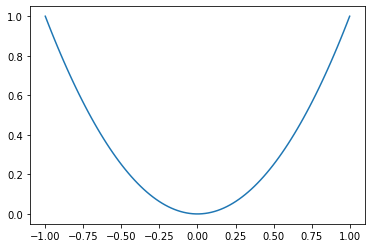

In [94]:
x = torch.linspace(-1, 1, 100, dtype=torch.double)
y = -x ** 2
_, = plt.plot(x, y)

In [103]:
num_epoch = 2000
model = icnn.ICNN(1, [100, 5, 1])
lr = 0.01
lossfn = nn.MSELoss()
verbose = True

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
          optimizer, num_epoch)
for epoch in range(num_epoch):
    model.zero_grad()
    yhat = model.forward(x.unsqueeze(0))
    loss = lossfn(yhat, y.unsqueeze(0))    
    if(verbose and epoch % 100 == 0):
        print('Epoch: {} \t Loss: {}'.format(epoch+1, loss.item()))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    scheduler.step()


/home/fengjun/.virtualenvs/general/lib/python3.8/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 	 Loss: 109446.09798352484
Epoch: 101 	 Loss: 0.2934285638288369
Epoch: 201 	 Loss: 0.12939000025346487
Epoch: 301 	 Loss: 0.1096091558714664
Epoch: 401 	 Loss: 0.1023126017977689
Epoch: 501 	 Loss: 0.09886349219608064
Epoch: 601 	 Loss: 0.09698364932152251
Epoch: 701 	 Loss: 0.09585812509265437
Epoch: 801 	 Loss: 0.09513822247567003
Epoch: 901 	 Loss: 0.09465512547216476
Epoch: 1001 	 Loss: 0.09431943399261537
Epoch: 1101 	 Loss: 0.09408040981185167
Epoch: 1201 	 Loss: 0.09390770672065336
Epoch: 1301 	 Loss: 0.09378234488200711
Epoch: 1401 	 Loss: 0.09369199048461273
Epoch: 1501 	 Loss: 0.093628299674168
Epoch: 1601 	 Loss: 0.09358534875541166
Epoch: 1701 	 Loss: 0.0935586319310841
Epoch: 1801 	 Loss: 0.09354434247639816
Epoch: 1901 	 Loss: 0.09353879781772208


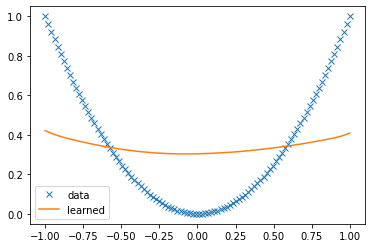

In [104]:
_, = plt.plot(x, y, 'x', label='data')
yhat = model.forward(x.unsqueeze(0)).detach()
plt.plot(x, yhat, label='learned')
_ = plt.legend()

## Experiment with trajectories generated using motion primitives

In [3]:
from __future__ import print_function, division
import quadrotortrajectorygen as quadtraj

# Define the trajectory starting state:
pos0 = [0, 0, 2]  # position
vel0 = [0, 0, 0]  # velocity
acc0 = [0, 0, 0]  # acceleration

# Define the goal state:
posf = [1, 0, 1]  # position
velf = [0, 0, 1]  # velocity
accf = [0, 9.81, 0]  # acceleration

# Define the duration:
Tf = 1

# Define the input limits:
fmin = 5  # [m/s**2]
fmax = 25  # [m/s**2]
wmax = 20  # [rad/s]
minTimeSec = 0.02  # [s]

# Define how gravity lies:
gravity = [0, 0, -9.81]

traj = quadtraj.RapidTrajectory(pos0, vel0, acc0, gravity)
traj.set_goal_position(posf)
traj.set_goal_velocity(velf)
traj.set_goal_acceleration(accf)

# Note: if you'd like to leave some states free, there are two options to
# encode this. As an example, we will be leaving the velocity in `x` (axis 0)
# free:
#
# Option 1:
# traj.set_goal_velocity_in_axis(1,velf_y);
# traj.set_goal_velocity_in_axis(2,velf_z);
#
# Option 2:
# traj.set_goal_velocity([None, velf_y, velf_z])

# Run the algorithm, and generate the trajectory.
traj.generate(Tf)

# Test input feasibility
inputsFeasible = traj.check_input_feasibility(fmin, fmax, wmax, minTimeSec)

# Test whether we fly into the floor
floorPoint = [0, 0, 0]  # a point on the floor
floorNormal = [0, 0, 1]  # we want to be in this direction of the point (upwards)
positionFeasible = traj.check_position_feasibility(floorPoint, floorNormal)

for i in range(3):
    print("Axis #", i)
    print("\talpha = ", traj.get_param_alpha(i), "\tbeta = ", traj.get_param_beta(i), "\tgamma = ",
          traj.get_param_gamma(i))
print("Total cost = ", traj.get_cost())
print("Input feasibility result: ", quadtraj.InputFeasibilityResult.to_string(inputsFeasible), "(", inputsFeasible, ")")
print("Position feasibility result: ", quadtraj.StateFeasibilityResult.to_string(positionFeasible), "(",
      positionFeasible, ")")


Axis # 0
	alpha =  720.0 	beta =  -360.0 	gamma =  60.0
Axis # 1
	alpha =  588.6 	beta =  -235.44 	gamma =  29.43
Axis # 2
	alpha =  -1080.0 	beta =  528.0 	gamma =  -84.0
Total cost =  3218.1249000000025
Input feasibility result:  Feasible ( 0 )
Position feasibility result:  Feasible ( 0 )


In [ ]:
# Run the LSTD estimator on trajectories
import lstd


numPlotPoints = 100
time = np.linspace(0, Tf, numPlotPoints)
position = np.zeros([numPlotPoints, 3])
velocity = np.zeros([numPlotPoints, 3])
acceleration = np.zeros([numPlotPoints, 3])
thrust = np.zeros([numPlotPoints, 1])
ratesMagn = np.zeros([numPlotPoints, 1])

for i in range(numPlotPoints):
    t = time[i]
    position[i, :] = traj.get_position(t)
    velocity[i, :] = traj.get_velocity(t)
    acceleration[i, :] = traj.get_acceleration(t)
    thrust[i] = traj.get_thrust(t)
    ratesMagn[i] = np.linalg.norm(traj.get_body_rates(t))


traj = lstd.construct_traj_list(xtrajs, utrajs, rtrajs)

# Train a tracking controller
K0 = np.random.random((q, p))
K, P = lstd.lspi(traj, 0.99, max_iter=50, sigma=sigma)
learned_ctrl = test_utils.linear_feedback_controller(K)
print('Relative error of value matrix is {:.3f}%'.format(test_utils.relerr(Pstar, P)*100))

## Test the functions from quad_utils.py

In [15]:
# from quad_utils import *
import numpy as np
from numpy.polynomial import Polynomial
import autograd.numpy as grad

p1d = np.poly1d([1, 2, 3])
print(p1d)
p2d = Polynomial([3, 2, 1])
print(p2d)
print(p1d(1))

print(p1d.deriv())

   2
1 x + 2 x + 3
3.0 + 2.0·x¹ + 1.0·x²
6
 
2 x + 2


In [16]:
p = []
p.append([1, 2, 3])
p.append([2, 3, 4])

print(np.array([p[0], p[1]]))

[[1 2 3]
 [2 3 4]]


In [30]:
import cvxpy as cp
import numpy as np

def sampler(poly, T, num_wayp):
    """
    Function to generate samples given polynomials
    :param coeff:
    :return:
    """
    return [poly[i](np.linspace(0, 1, Tref)) for i in range(num_waypt)]            


x = [np.poly1d([1, 2, 3]), np.poly1d([1, 5, 3])]
y = [np.poly1d([2, 3, 4]), np.poly1d([1, 2, 3])]
z = [np.poly1d([3, 4, 5]), np.poly1d([1, 2, 3])]

num_waypt = 2
g = 9.81
Tref = 25
order = 4

print(sampler(x, Tref, num_waypt))

ddot_ref = []
ddot_ref.append(sampler(x, Tref, num_waypt))
ddot_ref.append(sampler(y, Tref, num_waypt))
ddot_ref.append(sampler(z, Tref, num_waypt) + g*np.ones([num_waypt, Tref]))

l = np.vstack(ddot_ref).flatten()
l = np.reshape(l, [3, Tref*num_waypt], order='C')
print(l)
print(l.shape)
print(l[:, 0])

[array([3.        , 3.08506944, 3.17361111, 3.265625  , 3.36111111,
       3.46006944, 3.5625    , 3.66840278, 3.77777778, 3.890625  ,
       4.00694444, 4.12673611, 4.25      , 4.37673611, 4.50694444,
       4.640625  , 4.77777778, 4.91840278, 5.0625    , 5.21006944,
       5.36111111, 5.515625  , 5.67361111, 5.83506944, 6.        ]), array([3.        , 3.21006944, 3.42361111, 3.640625  , 3.86111111,
       4.08506944, 4.3125    , 4.54340278, 4.77777778, 5.015625  ,
       5.25694444, 5.50173611, 5.75      , 6.00173611, 6.25694444,
       6.515625  , 6.77777778, 7.04340278, 7.3125    , 7.58506944,
       7.86111111, 8.140625  , 8.42361111, 8.71006944, 9.        ])]
[[ 3.          3.08506944  3.17361111  3.265625    3.36111111  3.46006944
   3.5625      3.66840278  3.77777778  3.890625    4.00694444  4.12673611
   4.25        4.37673611  4.50694444  4.640625    4.77777778  4.91840278
   5.0625      5.21006944  5.36111111  5.515625    5.67361111  5.83506944
   6.          3.          3.

In [9]:
from quad_utils import *
import numpy
import trajgen
import scipy.linalg as spl
import matplotlib.pyplot as plt
import cvxpy as cp

import lstd
import test_utils


waypoints = [[0, 0, 0, 0],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [1, 1, 1, 1]]
waypoints = np.array(waypoints)
ts = [0, 0.33, 0.66, 1]
num_points = 20
tp = np.linspace(0, 1, 26)

Tref = 25
p = 4
q = 1


def generate(waypoints, ts, n, num_steps, p, P, rho, task='min-jerk'):
    ''' Wrapper for generating trajectory. For now only takes quadratic
    regularization.
    Return:
        ref:        reference trajectory
    '''
    objective, constr, ref, coeff = trajgen.min_jerk_setup(waypoints, ts, n, p, num_steps)
    P12 = P[0:p,p:]
    P22 = P[p:,p:]
    
    print(P12.shape)
    print(P22.shape)
    print(ref.shape)
    
    x0 = np.array(waypoints[0])
    penalty = cp.quad_form(ref, P22) + 2 * x0 @ (P12@ref)
    prob = cp.Problem(cp.Minimize(objective + rho * penalty), constr)
    prob.solve()
    if prob.status != cp.OPTIMAL:
        return None
    else:
        return coeff
    
rhos = np.concatenate([[0], np.logspace(4, 8, 3)])

A = linear_quad(None)
Qx, Rx = 100*np.zeros([p, p]), np.eye(q)
Qx[0, 0] = 1    
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(A.Ax, A.Bx, Qx, Rx, Tref)

Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)

static_ctrl = test_utils.linear_feedback_controller(Kstar)
    
coeffs = generate(waypoints, ts, 5, Tref+1, p, Pstar, rhos[0])


B = linear_quad(None)
d = B.compute_states(coeffs[0], coeffs[1], coeffs[2], coeffs[3])
# print(B.intermediate_qt(25, 4))

(4, 104)
(104, 104)
(104,)
(3, 6)
(3, 6)
(3, 6)
(3, 6)
(3, 6)
(3, 6)
Zw shape (75, 3)
(3, 6)
(3, 6)
(3, 6)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3,)
Y (3,)
Z (3,)
X (3

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 50 is different from 75)

In [107]:
print(len(d))
print(d[3])

38
r


In [67]:
import numpy as np

x = np.random.randn(3, 4)
print(x)

y = np.random.randn(3, 4)
print(y)

print(np.cross(x, y, axisa=1))

[[ 0.68677763 -2.06616291 -0.04620585 -0.24902921]
 [ 0.1348224  -0.58540944  1.02582652  1.74957678]
 [-0.15536843 -1.18004543 -0.85912345 -0.24524399]]
[[-1.629863    2.18277028  1.14654103 -0.54665363]
 [-0.85746258 -0.31493059 -1.39627696  1.24533638]
 [ 1.01392522 -0.82152947 -1.00800532 -0.41922142]]


ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

Yref (104,)
Xtraj (26, 108)
init state [ 1.03010445e+00  4.53792168e-01 -1.64853359e-02  5.17822223e-01
 -3.03190458e-08 -6.36403802e-09  0.00000000e+00 -1.80093066e+01
  7.22877742e-03  5.10046350e-01  0.00000000e+00  3.41559398e-01
  4.79941099e-02  1.56487806e+00  5.73824211e-02  3.62651387e-01
  1.31754186e-01  2.57535003e+00  0.00000000e+00  5.82411004e-01
  2.47703182e-01  3.11740513e+00  0.00000000e+00  3.37213554e+00
  3.71374744e-01  2.93207418e+00 -2.67609970e-02 -2.96056426e+00
  4.71245513e-01  1.92547594e+00  0.00000000e+00 -5.11175958e-01
  5.15338639e-01  1.68817121e-01  0.00000000e+00 -2.14936204e-01
  4.77827298e-01 -2.10160761e+00  4.03076776e-02 -1.32640924e-01
  3.50760028e-01 -4.14527381e+00  0.00000000e+00 -1.98794387e-01
  1.51466793e-01 -5.72708029e+00  0.00000000e+00 -4.78267043e-01
 -9.78361106e-02 -6.59535942e+00  2.14140021e-01 -2.94616342e+00
 -3.63408654e-01 -6.51138459e+00  0.00000000e+00 -3.27261534e+00
 -6.04508161e-01 -5.36375003e+00  0.00000000e+00 -3

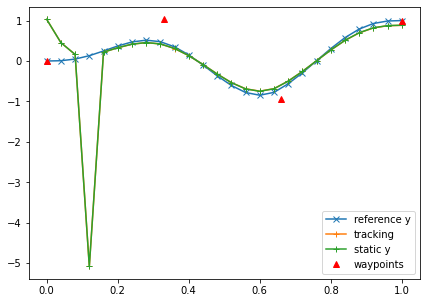

Yref (104,)
Xtraj (26, 108)
init state [ 1.03010445e+00  4.53792168e-01 -1.64853359e-02  5.17822223e-01
 -3.36213440e-08 -7.05730259e-09  0.00000000e+00 -1.80099694e+01
  7.22877389e-03  5.10046336e-01  0.00000000e+00  3.41325188e-01
  4.79941053e-02  1.56487802e+00  5.63975834e-02  3.64543253e-01
  1.31754180e-01  2.57534997e+00  0.00000000e+00  5.88203760e-01
  2.47703173e-01  3.11740508e+00  0.00000000e+00  3.38669583e+00
  3.71374733e-01  2.93207416e+00 -3.18676614e-02 -3.07787727e+00
  4.71245503e-01  1.92547598e+00  0.00000000e+00 -5.28987481e-01
  5.15338632e-01  1.68817255e-01  0.00000000e+00 -2.22834151e-01
  4.77827299e-01 -2.10160737e+00  3.83669005e-02 -1.39741679e-01
  3.50760038e-01 -4.14527359e+00  0.00000000e+00 -1.96460580e-01
  1.51466810e-01 -5.72708016e+00  0.00000000e+00 -4.77931168e-01
 -9.78360905e-02 -6.59535942e+00  2.13787766e-01 -2.89551728e+00
 -3.63408637e-01 -6.51138476e+00  0.00000000e+00 -3.34526042e+00
 -6.04508155e-01 -5.36375043e+00  0.00000000e+00 -3

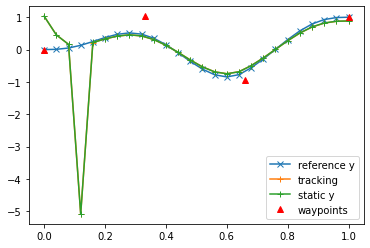

Yref (104,)
Xtraj (26, 108)
init state [ 1.03010445e+00  4.53792168e-01 -1.64853359e-02  5.17822223e-01
 -1.11453677e-12 -2.33882000e-13  0.00000000e+00 -1.83213039e+01
  7.22880733e-03  5.10046310e-01  0.00000000e+00  3.64384165e-01
  4.79941363e-02  1.56487792e+00  1.50593029e-02  5.03228675e-01
  1.31754205e-01  2.57534979e+00  0.00000000e+00  9.20951147e-01
  2.47703189e-01  3.11740482e+00  0.00000000e+00  3.35751855e+00
  3.71374738e-01  2.93207386e+00 -4.16309071e-02 -2.04725947e+00
  4.71245496e-01  1.92547567e+00  0.00000000e+00 -1.67772200e+00
  5.15338613e-01  1.68816955e-01  0.00000000e+00 -9.14665636e-01
  4.77827268e-01 -2.10160764e+00 -1.81192524e-02 -7.99241883e-01
  3.50760007e-01 -4.14527371e+00  0.00000000e+00 -3.32294134e-02
  1.51466779e-01 -5.72708007e+00  0.00000000e+00 -3.80043304e-01
 -9.78361138e-02 -6.59535912e+00  2.12853268e-01 -1.94818511e+00
 -3.63408644e-01 -6.51138425e+00  0.00000000e+00 -4.88759131e+00
 -6.04508138e-01 -5.36374971e+00  0.00000000e+00 -1

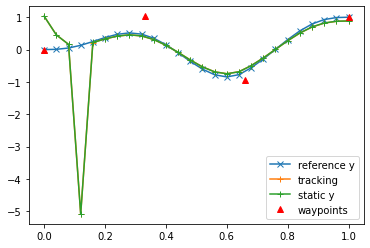

Yref (104,)
Xtraj (26, 108)
init state [ 1.03010445e+00  4.53792168e-01 -1.64853359e-02  5.17822223e-01
  9.21944743e-16  3.13072729e-16  0.00000000e+00 -1.82424085e+01
  7.22880444e-03  5.10046111e-01  0.00000000e+00 -8.46938244e-01
  4.79941188e-02  1.56487739e+00 -2.63288709e-02  8.85562942e-01
  1.31754162e-01  2.57534909e+00  0.00000000e+00  2.48620721e+00
  2.47703120e-01  3.11740426e+00  0.00000000e+00  1.39121010e+00
  3.71374654e-01  2.93207373e+00  1.92864406e-01  1.10812600e+00
  4.71245418e-01  1.92547615e+00  0.00000000e+00  3.47288893e-01
  5.15338565e-01  1.68817912e-01  0.00000000e+00 -5.08004281e+00
  4.77827260e-01 -2.10160676e+00  1.69921315e-01 -1.08355757e+00
  3.50760021e-01 -4.14527345e+00  0.00000000e+00  3.18840466e+00
  1.51466799e-01 -5.72707994e+00  0.00000000e+00 -5.05427360e+00
 -9.78360878e-02 -6.59535895e+00  2.50814873e-01 -1.29309227e+00
 -3.63408611e-01 -6.51138409e+00  0.00000000e+00  6.86904824e-01
 -6.04508101e-01 -5.36374973e+00  0.00000000e+00  1

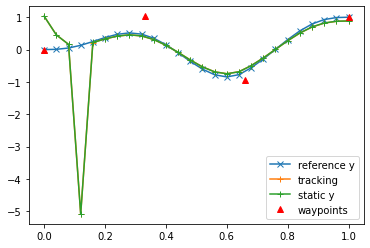

In [10]:
from quad_utils import *
import numpy
import trajgen
import scipy.linalg as spl
import matplotlib.pyplot as plt
import cvxpy as cp

import lstd
import test_utils


def generate(waypoints, ts, n, num_steps, p, P, rho, task='min-jerk'):
    """ Wrapper for generating trajectory. For now only takes quadratic
    regularization.
    Return:
        ref:        reference trajectory
    """
    objective, constr, ref, coeff = trajgen.min_jerk_setup(waypoints, ts, n, p, num_steps)
    P12 = P[0:p,p:]
    P22 = P[p:,p:]
    
    x0 = np.array(waypoints[0])
    penalty = cp.quad_form(ref, P22) + 2 * x0 @ (P12@ref)
    prob = cp.Problem(cp.Minimize(objective + rho * penalty), constr)
    prob.solve()
    if prob.status != cp.OPTIMAL:
        return None
    else:
        return coeff
    
    

quad = linear_quad(dist=None)
Ax = quad.Ax
Bx = quad.Bx

Ay = quad.Ay
By = quad.By

# Generating x, y, z, yaw waypoints

waypoints = [[0, 0, 0, 0],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [1, 1, 1, 1]]
waypoints = np.array(waypoints)
ts = [0, 0.33, 0.66, 1]
num_points = 20

# LQR Controller for x-subsystem

p = 4
q = 1

sigma = 0

Qx, Rx = 100*np.zeros([p, p]), np.eye(q)
Qx[0, 0] = 1

Tref = 25
# T = Tref*3
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(Ay, By, Qx, Rx, Tref)

Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)

static_ctrl = test_utils.linear_feedback_controller(Kstar)

# Solve for a time-varying controller using value iteration
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, 100, 0.99)
vi_ctrlr = test_utils.TVcontroller(Kvi[:])


# Spline trajectory
rhos = np.concatenate([[0], np.logspace(4, 8, 3)])
tp = np.linspace(0, 1, 26)

plt.figure(figsize=(7, 5))
for i, rho in enumerate(rhos):
    
    coeffs = generate(waypoints, ts, 5, Tref+1, p, P=Pstar, rho=rho)
    ref = quad.compute_states(coeffs[0], coeffs[1], coeffs[2], coeffs[3], ts, Tref+1)
    
    xref = np.dstack([ref[0], ref[1], ref[8], ref[9]]).flatten()
    yref = np.dstack([ref[2], ref[3], ref[6], ref[7]]).flatten()
    
    print("Yref", yref.shape)
    
    d0 = np.concatenate([waypoints[1], yref])
    
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, static_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)
    
    # plt.subplot(3, len(rhos), i+1+len(rhos))
    plt.plot(tp, yref[0::p], 'x-', label='reference y')
    plt.plot(tp, xvi[:, 0], '+-', label='tracking')
    plt.plot(tp, xtraj[:, 0], '+-', label='static y')
    plt.plot(ts, waypoints[:, 0], 'r^', label='waypoints')
    plt.legend()
    
    # plt.subplot(3, len(rhos), i+1+2*len(rhos))
    # plt.plot(np.arange(Tref), np.abs(utraj), '+--', label='static')
    # plt.plot(np.arange(Tref), np.abs(uvi), '+--', label='opt')
    # plt.legend()
    plt.show()

In [21]:
from quad_utils import *
import numpy
import trajgen
import scipy.linalg as spl
import matplotlib.pyplot as plt
import cvxpy as cp

import lstd
import test_utils


def generate(waypoints, ts, n, num_steps, p, P, rho, task='min-jerk'):
    """ Wrapper for generating trajectory. For now only takes quadratic
    regularization.
    Return:
        ref:        reference trajectory
    """
    objective, constr, ref, coeff = trajgen.min_jerk_setup(waypoints, ts, n, p, num_steps)
    P12 = P[0:p,p:]
    P22 = P[p:,p:]
    print("Ref", ref.shape)
    x0 = np.array(waypoints[0])
    penalty = cp.quad_form(ref, P22) + 2 * x0 @ (P12@ref)
    prob = cp.Problem(cp.Minimize(objective + rho * penalty), constr)
    prob.solve()
    if prob.status != cp.OPTIMAL:
        return None
    else:
        return coeff
    
    

quad = linear_quad(dist=None)
Ax = quad.Ax
Bx = quad.Bx

Ay = quad.Ay
By = quad.By

Az = quad.Az
Bz = quad.Bz

# Generating x, y, z, yaw waypoints

waypoints = [[0, 0, 0, 0],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [np.random.randn(), np.random.randn(), np.random.randn(), np.random.randn()],
             [1, 1, 1, 1]]
waypoints = np.array(waypoints)
ts = [0, 0.33, 0.66, 1]
num_points = 20

# LQR Controller for z-subsystem
p_traj = 4

p = 2
q = 1

sigma = 0

Qz, Rz = 100*np.zeros([p, p]), np.eye(q)
Qz[0, 0] = 1

Tref = 25
# T = Tref*3
# Construct augmented system for tracking
At, Bt, Qt, Rt = lstd.nominal_to_tracking(Az, Bz, Qz, Rz, Tref)

Pstar = spl.solve_discrete_are(At, Bt, Qt, Rt)
Kstar = -np.linalg.pinv(Bt.T @ Pstar @ Bt + Rt) @ (Bt.T @ Pstar @ At)

static_ctrl = test_utils.linear_feedback_controller(Kstar)

# Solve for a time-varying controller using value iteration
Pvi, Kvi = test_utils.lqr_vi(At, Bt, Qt, Rt, 100, 0.99)
vi_ctrlr = test_utils.TVcontroller(Kvi[:])


# Spline trajectory
rhos = np.concatenate([[0], np.logspace(4, 8, 3)])
print("Rhos", rhos)
tp = np.linspace(0, 1, 26)

plt.figure(figsize=(7, 5))
for i, rho in enumerate(rhos):
    
    coeffs = generate(waypoints, ts, 5, Tref+1, 2, P=Pstar, rho=rho)
    ref = quad.compute_states(coeffs[0], coeffs[1], coeffs[2], coeffs[3], ts, Tref+1)
    
    zref = np.dstack([ref[4], ref[5]]).flatten()
    
    print("Zref", zref.shape)
    
    print(waypoints[0])
    
    d0 = np.concatenate([waypoints[0], zref])
    
    xtraj, utraj, rtraj = test_utils.sample_traj(At, Bt, Qt, Rt, static_ctrl, Tref, d0, sigma=0)
    vi_ctrlr = test_utils.TVcontroller(Kvi[:])
    xvi, uvi, rvi = test_utils.sample_traj(At, Bt, Qt, Rt, vi_ctrlr.ctrl, Tref, d0, sigma=0)
    
    # plt.subplot(3, len(rhos), i+1+len(rhos))
    plt.plot(tp, yref[0::p], 'x-', label='reference y')
    plt.plot(tp, xvi[:, 0], '+-', label='tracking')
    plt.plot(tp, xtraj[:, 0], '+-', label='static y')
    plt.plot(ts, waypoints[:, 0], 'r^', label='waypoints')
    plt.legend()
    
    # plt.subplot(3, len(rhos), i+1+2*len(rhos))
    # plt.plot(np.arange(Tref), np.abs(utraj), '+--', label='static')
    # plt.plot(np.arange(Tref), np.abs(uvi), '+--', label='opt')
    # plt.legend()
    plt.show()

Rhos [0.e+00 1.e+04 1.e+06 1.e+08]
Ref (52,)


ValueError: Incompatible dimensions (1, 4) (2, 1)

<Figure size 504x360 with 0 Axes>

In [11]:
ts = np.array(ts)
ts[1:] - ts[:-1]

array([0.33, 0.33, 0.34])